In [15]:
# 数据处理
import pandas as pd
import numpy as np

# 模型和评估
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# 数据分割和交叉验证
from sklearn.model_selection import GroupShuffleSplit, GroupKFold

# 特征预处理
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('parkinsons_updrs.data')

random_state = 42
y = df['total_UPDRS']
X = df.loc[:, ~df.columns.isin(['total_UPDRS', 'test_time', 'Jitter(%)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
                                 'Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA'])]
groups = df['subject#']

# Split into test and other sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.8, random_state=random_state)
test_idx, other_idx = next(gss.split(X, y, groups))

X_test, y_test, groups_test = X.iloc[test_idx], y.iloc[test_idx], groups.iloc[test_idx]
X_other, y_other, groups_other = X.iloc[other_idx], y.iloc[other_idx], groups.iloc[other_idx]

param_grid = {'n_estimators': [200, 250, 300, 500], 'max_depth': [5, 10, 15, 20]}

test_scores = []
best_models = []
group_kfold = GroupKFold(n_splits=4)

# Preprocessing pipeline
onehot_ftrs = ['sex']
std_ftrs = [col for col in X.columns if col != 'sex']  # 动态生成特征列表

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)
    ]
)

best_params = None
best_val_rmse = float('inf')
best_model = None

for train_idx, val_idx in group_kfold.split(X_other, y_other, groups_other):
    X_train, X_val = X_other.iloc[train_idx], X_other.iloc[val_idx]
    y_train, y_val = y_other.iloc[train_idx], y_other.iloc[val_idx]

    clf = Pipeline(steps=[('preprocessor', preprocessor)])
    X_train_prep = clf.fit_transform(X_train)
    X_val_prep = clf.transform(X_val)
    X_test_prep = clf.transform(X_test)

    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
            model.fit(X_train_prep, y_train)
            
            y_val_pred = model.predict(X_val_prep)
            val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            print(f"Params: n_estimators={n_estimators}, max_depth={max_depth}, Validation RMSE: {val_rmse:.4f}")

            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_params = (n_estimators, max_depth)
                best_model = model

    # 测试集上评估最佳模型
    y_test_pred = best_model.predict(X_test_prep)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_scores.append(test_rmse)
    best_models.append(best_model)

    print(f"Best Params: {best_params}, Test RMSE: {test_rmse:.4f}")

print(np.std(test_scores))

# 输出表现最佳的模型
best_model_index = np.argmin(test_scores)
global_best_model = best_models[best_model_index]
print("\nBest Model Across All Random States:")
print(global_best_model)

Params: n_estimators=100, max_depth=5, Validation RMSE: 5.8894
Params: n_estimators=100, max_depth=10, Validation RMSE: 5.6766
Params: n_estimators=100, max_depth=15, Validation RMSE: 5.6867
Params: n_estimators=100, max_depth=20, Validation RMSE: 5.6817
Params: n_estimators=100, max_depth=40, Validation RMSE: 5.6633
Params: n_estimators=200, max_depth=5, Validation RMSE: 5.8814
Params: n_estimators=200, max_depth=10, Validation RMSE: 5.6904
Params: n_estimators=200, max_depth=15, Validation RMSE: 5.6933
Params: n_estimators=200, max_depth=20, Validation RMSE: 5.6915
Params: n_estimators=200, max_depth=40, Validation RMSE: 5.6838
Params: n_estimators=250, max_depth=5, Validation RMSE: 5.8868
Params: n_estimators=250, max_depth=10, Validation RMSE: 5.6914
Params: n_estimators=250, max_depth=15, Validation RMSE: 5.6840
Params: n_estimators=250, max_depth=20, Validation RMSE: 5.6941
Params: n_estimators=250, max_depth=40, Validation RMSE: 5.6877
Params: n_estimators=300, max_depth=5, Vali

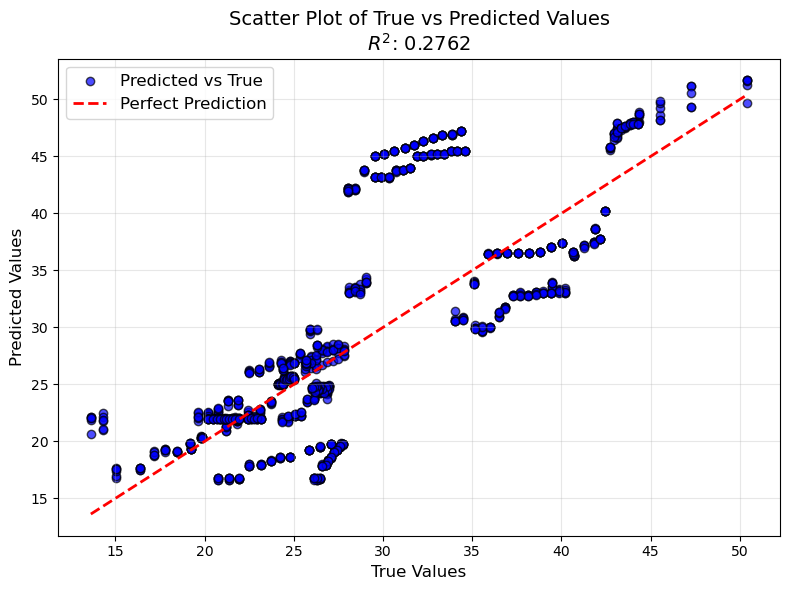

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R^2 score
r2 = r2_score(y_test, y_test_pred)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue', edgecolor='k', label='Predicted vs True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title(f"Scatter Plot of True vs Predicted Values\n$R^2$: {r2:.4f}", fontsize=14)
plt.xlabel("True Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
